In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import graphviz
from sklearn.tree import export_graphviz

In [2]:
# Load the dataset from CSV file
file_path = 'data.csv'  
df = pd.read_csv(file_path)

# Summary statistics
print("Summary statistics:")
df.describe(include='all')

Summary statistics:


,Age,Education_Level,Occupation,Number_of_Dependents,Location,Work_Experience,Marital_Status,Employment_Status,Household_Size,Homeownership_Status,Type_of_Housing,Gender,Primary_Mode_of_Transportation,Income
count,10000.000000,10000,10000,10000.000000,10000,10000.000000,10000,10000,10000.000000,10000,10000,10000,10000,1.000000e+04
unique,NaN,4,5,NaN,3,NaN,3,3,NaN,2,3,2,4,NaN
top,NaN,Bachelor's,Healthcare,NaN,Urban,NaN,Married,Full-time,NaN,Own,Single-family home,Male,Public transit,NaN
freq,NaN,4058,3035,NaN,7037,NaN,5136,5004,NaN,6018,4055,5123,4047,NaN
mean,44.021700,NaN,NaN,2.527000,NaN,24.858800,NaN,NaN,3.989600,NaN,NaN,NaN,NaN,8.168382e+05
std,15.203998,NaN,NaN,1.713991,NaN,14.652622,NaN,NaN,2.010496,NaN,NaN,NaN,NaN,1.821089e+06
min,18.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,3.104400e+04
25%,31.000000,NaN,NaN,1.000000,NaN,12.000000,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,6.844600e+04
50%,44.000000,NaN,NaN,3.000000,NaN,25.000000,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,7.294300e+04
75%,57.000000,NaN,NaN,4.000000,NaN,37.000000,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,3.506675e+05


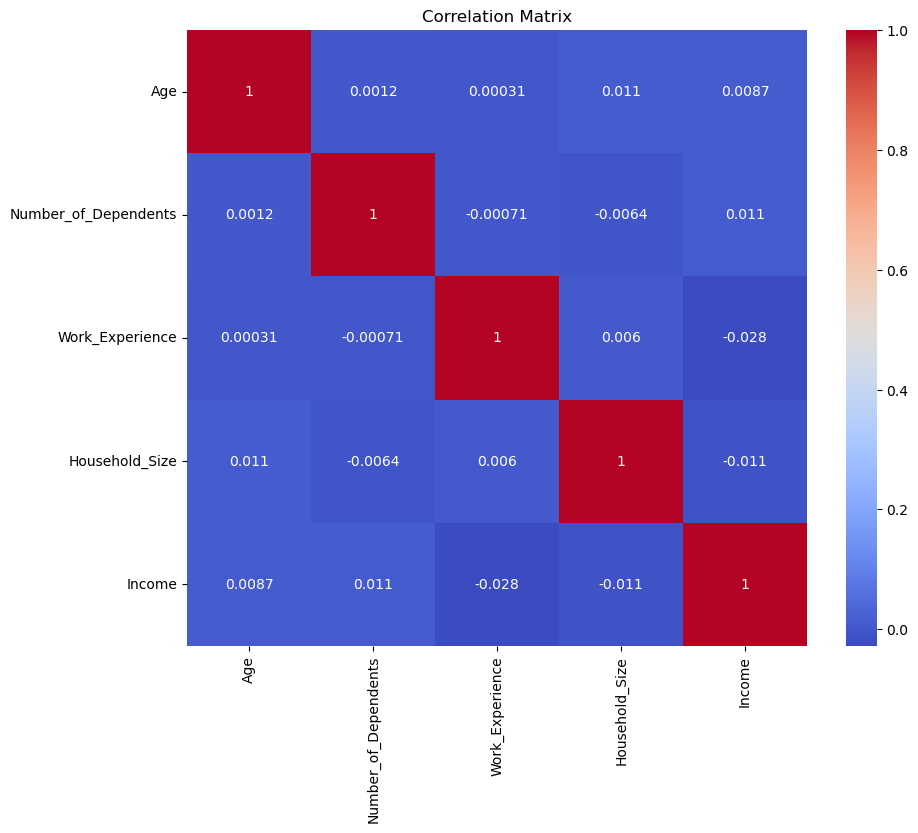

In [3]:
# Correlation matrix for numeric columns only
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

C:\Users\luddi\anaconda3\envs\TensorFlow_Env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


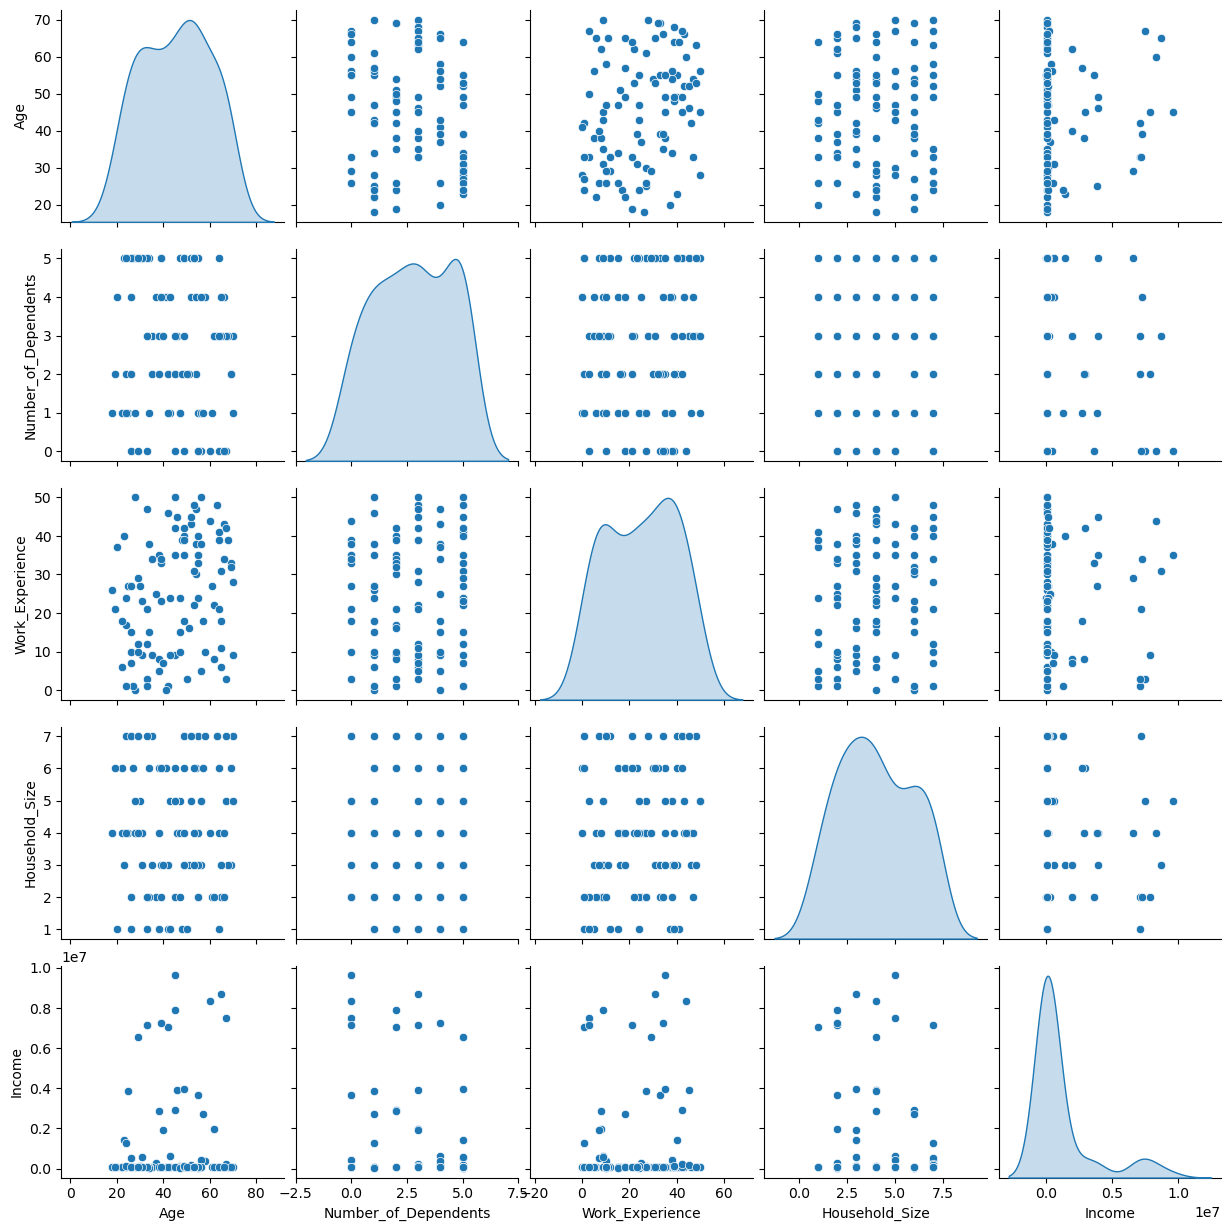

In [4]:
# Pairplot for visualizing relationships (using a subset to avoid overloading the plot)
sns.pairplot(df.sample(min(100, len(df))), diag_kind='kde')
plt.show()

In [5]:
# Filter the dataset to include only households with incomes up to 500,000 USD
df = df[df['Income'] <= 500000]

In [6]:
# Splitting the dataset
train_df, val_df = train_test_split(df, test_size=0.2, random_state=0)

# Define preprocessing for numeric and categorical features
numeric_features = ['Age', 'Number_of_Dependents', 'Work_Experience', 'Household_Size']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

categorical_features = ['Education_Level', 'Occupation', 'Location', 'Marital_Status', 
                        'Employment_Status', 'Homeownership_Status', 'Type_of_Housing', 
                        'Gender', 'Primary_Mode_of_Transportation']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the PCA for dimensionality reduction
pca = PCA(n_components=10)  # Number of components 

# Define the Random Forest Regressor
random_forest = RandomForestRegressor(random_state=0)

# Create a pipeline that preprocesses the data, applies PCA, and then fits the Random Forest model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('pca', pca),
                        ('regressor', random_forest)])

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)
fold = 1
for train_index, test_index in kf.split(train_df):
    train_kf, test_kf = train_df.iloc[train_index], train_df.iloc[test_index]
    model.fit(train_kf.drop('Income', axis=1), train_kf['Income'])
    predictions = model.predict(test_kf.drop('Income', axis=1))
    rmse = mean_squared_error(test_kf['Income'], predictions, squared=False)
    r2 = r2_score(test_kf['Income'], predictions)
    print(f"Fold {fold} - RMSE: {rmse}, R^2: {r2}")
    fold += 1

Fold 1 - RMSE: 83056.15090438344, R^2: -0.05903794557559605
Fold 2 - RMSE: 82901.62620880139, R^2: -0.13304886403628569
Fold 3 - RMSE: 85348.09399375136, R^2: -0.08989352406343598
Fold 4 - RMSE: 80874.02160107263, R^2: -0.07609441077686685
Fold 5 - RMSE: 82381.06715370172, R^2: -0.09479082510418402


In [7]:
# Final evaluation on the validation set
model.fit(train_df.drop('Income', axis=1), train_df['Income'])
val_predictions = model.predict(val_df.drop('Income', axis=1))
val_rmse = mean_squared_error(val_df['Income'], val_predictions, squared=False)
val_r2 = r2_score(val_df['Income'], val_predictions)

print(f"Validation - RMSE: {val_rmse}, R^2: {val_r2}")

Validation - RMSE: 74528.7325025644, R^2: -0.12024568617057207


In [8]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_df.drop('Income', axis=1), train_df['Income'])

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}


In [9]:
# Evaluate the best model
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(val_df.drop('Income', axis=1))
val_rmse = mean_squared_error(val_df['Income'], val_predictions, squared=False)
val_r2 = r2_score(val_df['Income'], val_predictions)

print(f"Best Model Validation - RMSE: {val_rmse}, R^2: {val_r2}")

Best Model Validation - RMSE: 71043.74082024158, R^2: -0.01792891741189906
